In [ ]:
# from fedot_ind.tools.explain.explainer import Explainer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import shap
import sklearn

In [2]:
from fedot_ind.api.main import FedotIndustrial
from fedot_ind.tools.loader import DataLoader

2023-11-30 18:49:46.528721: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
dataset_name = 'ItalyPowerDemand'
train_data, test_data = DataLoader(dataset_name=dataset_name).load_data()
industrial = FedotIndustrial(task='ts_classification',
                                 dataset=dataset_name,
                                 strategy='topological',
                                 use_cache=False,
                                 timeout=0.1,
                                 logging_level=50,
                                 available_operations=['scaling', 'normalization', 'xgboost', 'rfr',
                                                       'rf', 'logit', 'mlp', 'knn', 'lgbm', 'pca']
                            )

model = industrial.fit(features=train_data[0], target=train_data[1])
labels = industrial.predict(features=test_data[0], target=test_data[1])
probs = industrial.predict_proba(features=test_data[0], target=test_data[1])
metrics = industrial.get_metrics(target=test_data[1], metric_names=['f1', 'roc_auc', 'accuracy'])


2023-11-30 18:50:03,554 INFO: FedotIndustrialAPI - Initialising experiment setup
2023-11-30 18:50:03,560 INFO: Configurator - Experiment setup:
2023-11-30 18:50:03,562 INFO: Configurator - task - ts_classification
2023-11-30 18:50:03,563 INFO: Configurator - dataset - ItalyPowerDemand
2023-11-30 18:50:03,565 INFO: Configurator - strategy - topological
2023-11-30 18:50:03,569 INFO: Configurator - use_cache - False
2023-11-30 18:50:03,571 INFO: FedotIndustrialAPI - Initialising solver
2023-11-30 18:50:03,573 INFO: TimeSeriesClassifier - TimeSeriesClassifier initialised
2023-11-30 18:50:03,575 INFO: TimeSeriesClassifier - Fitting model


  0%|          | 0/5 [00:00<?, ?it/s]

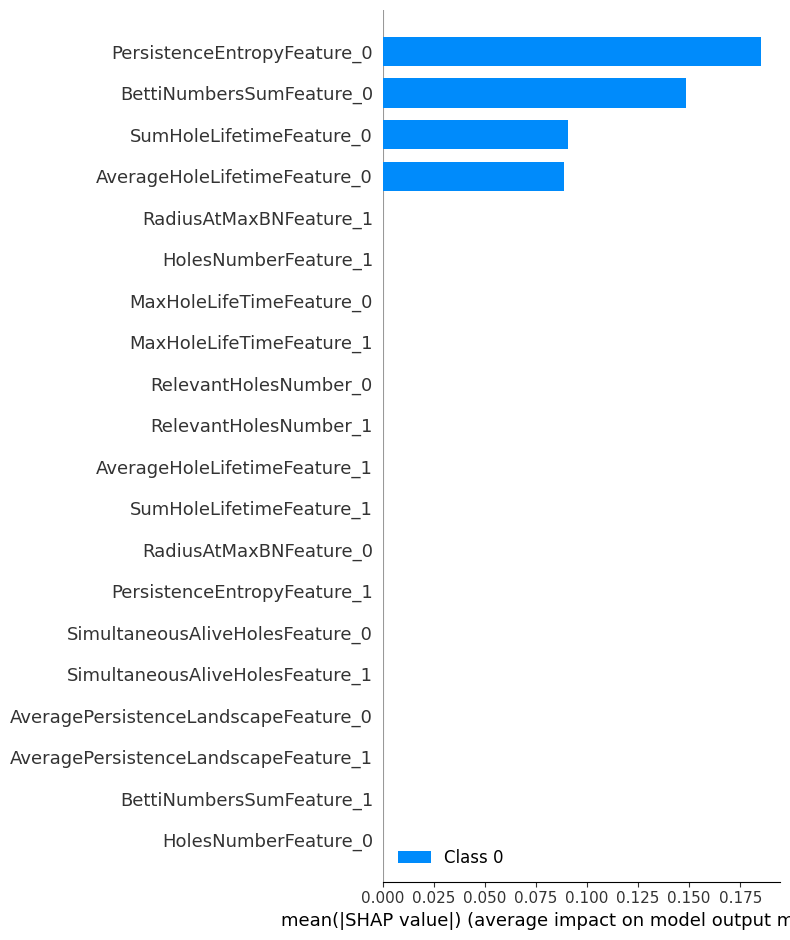

In [4]:
from fedot_ind.tools.explain.explain import Explainer, ShapExplainer

n_samples = 5
explainer = ShapExplainer(model=industrial.solver.predictor,
                          features=industrial.solver.test_features,
                          target=test_data[1],
                          prediction=industrial.solver.prediction_label,
                      )
explainer.explain(n_samples=n_samples)

100%|██████████| 24/24 [00:06<00:00,  3.77it/s]


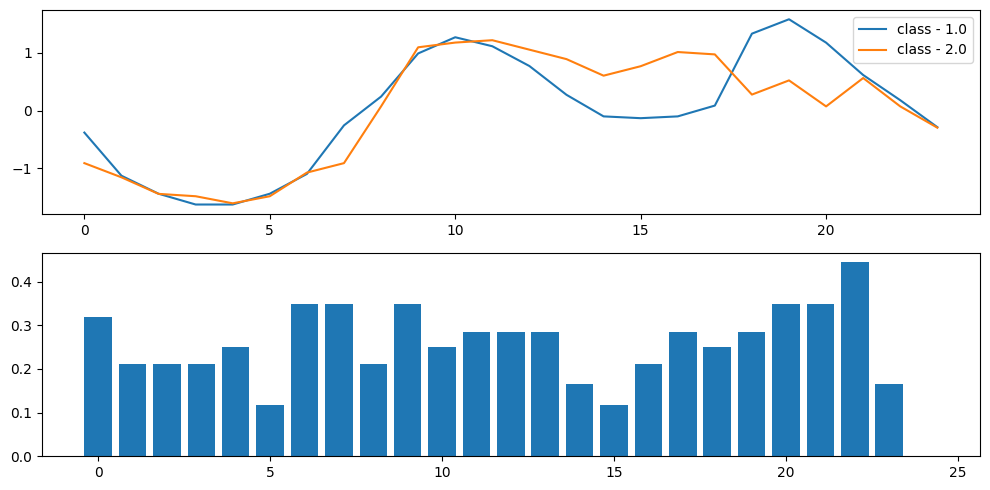

In [16]:
from tqdm import tqdm


class Explain:
    def __init__(self, model, test_features, test_target, window = 3):
        self.model = model
        self.test_features = test_features
        self.test_target = test_target

    def select(self, n_samples: int = 3):
        # df = self.test_features
        selected_df = pd.DataFrame()
        selected_target = np.array([])
        df = self.test_features
        df['target'] = self.test_target

        for class_label in np.unique(self.test_target):
            class_samples = df[df['target'] == class_label].sample(n=n_samples, replace=False)
            selected_df = pd.concat([selected_df, class_samples.iloc[:, :-1]])
            selected_target = np.concatenate([selected_target, class_samples['target'].to_numpy()])

        return selected_df, selected_target

    def explain(self, by_n_samples: int = 2):
        n = self.test_features.shape[1]
        metric_name = self.assess_metric(self.test_target)

        features_part, target_part = self.select(n_samples=by_n_samples)

        # base_metric_value = self.model.get_metrics(target=self.test_target,
        #                                             metric_names=[metric_name])[metric_name]

        self.model.solver.test_features = None
        base_predict = self.model.predict(features=features_part, target=target_part)
        base_metric_value = self.model.get_metrics(target=target_part,
                                                    metric_names=[metric_name])[metric_name]

        importance_vector = np.zeros(n)

        for i in tqdm(range(n - 1)):
            features = features_part.copy()
            # replacement_value = np.mean(features.iloc[:, i].values)
            replacement_value = features.iloc[:, i].values.mean()
            features.iloc[:, i] = replacement_value
            self.model.solver.test_features = None
            # features.iloc[:, i] = np.random.permutation(features.iloc[:, i])
            labels = self.model.predict(features=features, target=target_part)
            # labels = self.model.predict(features=features, target=self.test_target)
            # new_metric_value = self.model.get_metrics(target=self.test_target,
            #                                           metric_names=[metric_name])[metric_name]
            new_metric_value = self.model.get_metrics(target=target_part,
                                                      metric_names=[metric_name])[metric_name]
            importance_vector[i] = abs(base_metric_value / new_metric_value - 1)


        return importance_vector

    def plot_importance_vector_and_time_series(self, importance_vector, time_series='random'):
        fig, ax = plt.subplots(2, 1, figsize=(10, 5))

        if time_series is 'random':
            rnd_value = np.random.randint(0, self.test_features.shape[0])
            time_series = self.test_features.iloc[rnd_value, :].values
            ax[0].plot(time_series)

        else:
            select_features, select_target = self.select(n_samples=time_series)
            for idx, cls in enumerate(select_target):
                ax[0].plot(select_features.iloc[idx, :].values, label=f'class - {cls}')

            ax[0].legend()

        # ax[1].plot(importance_vector)
        ax[1].bar(np.arange(len(importance_vector)), importance_vector)
        fig.tight_layout()
        plt.show()

    def assess_metric(self, target):
        n_classes = len(np.unique(target))
        return 'roc_auc' if n_classes == 2 else 'f1'

explainer = Explain(industrial, test_data[0], test_data[1])
importance_vector = explainer.explain(by_n_samples=20)
explainer.plot_importance_vector_and_time_series(importance_vector, time_series=1)


100%|██████████| 24/24 [00:07<00:00,  3.00it/s]


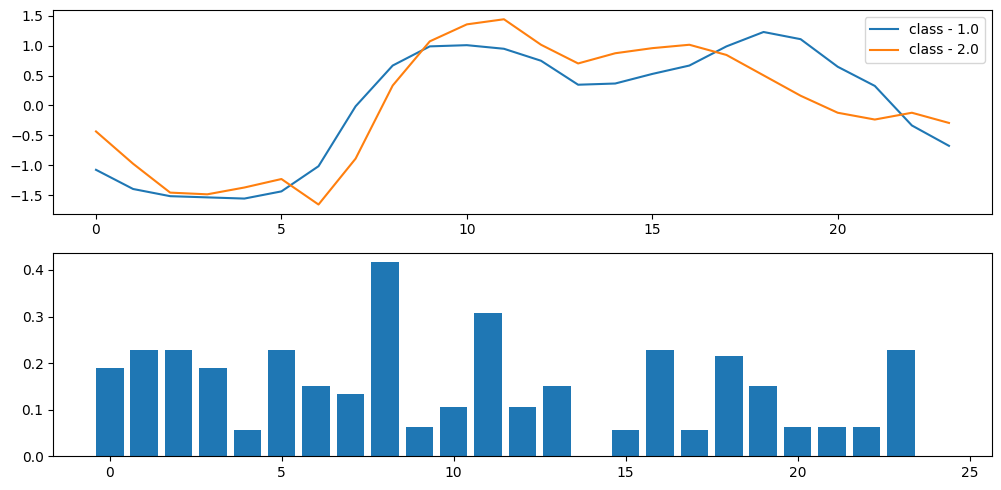

In [17]:
from tqdm import tqdm


class Explain:
    def __init__(self, model, test_features, test_target, window = 3):
        self.model = model
        self.test_features = test_features
        self.test_target = test_target

    def select(self, n_samples: int = 3):
        # df = self.test_features
        selected_df = pd.DataFrame()
        selected_target = np.array([])
        df = self.test_features
        df['target'] = self.test_target

        for class_label in np.unique(self.test_target):
            class_samples = df[df['target'] == class_label].sample(n=n_samples, replace=False)
            selected_df = pd.concat([selected_df, class_samples.iloc[:, :-1]])
            selected_target = np.concatenate([selected_target, class_samples['target'].to_numpy()])

        return selected_df, selected_target

    def explain(self, by_n_samples: int = 2):
        n = self.test_features.shape[1]
        metric_name = self.assess_metric(self.test_target)

        features_part, target_part = self.select(n_samples=by_n_samples)

        # base_metric_value = self.model.get_metrics(target=self.test_target,
        #                                             metric_names=[metric_name])[metric_name]

        self.model.solver.test_features = None
        base_predict = self.model.predict(features=features_part, target=target_part)
        base_metric_value = self.model.get_metrics(target=target_part,
                                                    metric_names=[metric_name])[metric_name]

        importance_vector = np.zeros(n)

        for i in tqdm(range(n - 1)):
            features = features_part.copy()
            # replacement_value = np.mean(features.iloc[:, i].values)
            replacement_value = 0
            features.iloc[:, i] = replacement_value
            self.model.solver.test_features = None
            # features.iloc[:, i] = np.random.permutation(features.iloc[:, i])
            labels = self.model.predict(features=features, target=target_part)
            # labels = self.model.predict(features=features, target=self.test_target)
            # new_metric_value = self.model.get_metrics(target=self.test_target,
            #                                           metric_names=[metric_name])[metric_name]
            new_metric_value = self.model.get_metrics(target=target_part,
                                                      metric_names=[metric_name])[metric_name]
            importance_vector[i] = abs(base_metric_value / new_metric_value - 1)


        return importance_vector

    def plot_importance_vector_and_time_series(self, importance_vector, time_series='random'):
        fig, ax = plt.subplots(2, 1, figsize=(10, 5))

        if time_series is 'random':
            rnd_value = np.random.randint(0, self.test_features.shape[0])
            time_series = self.test_features.iloc[rnd_value, :].values
            ax[0].plot(time_series)

        else:
            select_features, select_target = self.select(n_samples=time_series)
            for idx, cls in enumerate(select_target):
                ax[0].plot(select_features.iloc[idx, :].values, label=f'class - {cls}')

            ax[0].legend()

        # ax[1].plot(importance_vector)
        ax[1].bar(np.arange(len(importance_vector)), importance_vector)
        fig.tight_layout()
        plt.show()

    def assess_metric(self, target):
        n_classes = len(np.unique(target))
        return 'roc_auc' if n_classes == 2 else 'f1'

explainer = Explain(industrial, test_data[0], test_data[1])
importance_vector = explainer.explain(by_n_samples=20)
explainer.plot_importance_vector_and_time_series(importance_vector, time_series=1)


In [4]:
from fedot_ind.api.main import FedotIndustrial
from fedot_ind.tools.loader import DataLoader

dataset_name = 'ItalyPowerDemand'
train_data, test_data = DataLoader(dataset_name=dataset_name).load_data()
industrial_quantile = FedotIndustrial(task='ts_classification',
                                 dataset=dataset_name,
                                 strategy='quantile',
                                 use_cache=False,
                                 timeout=0.1,
                                 logging_level=50,
                                 available_operations=['scaling', 'normalization', 'xgboost', 'rfr',
                                                       'rf', 'logit', 'mlp', 'knn', 'lgbm', 'pca']
                            )


model_quantile = industrial_quantile.fit(features=train_data[0], target=train_data[1])
labels_quantile = industrial_quantile.predict(features=test_data[0], target=test_data[1])
probs_quantile = industrial_quantile.predict_proba(features=test_data[0], target=test_data[1])
metrics_quantile = industrial_quantile.get_metrics(target=test_data[1], metric_names=['f1',
                                                                                      'roc_auc',
                                                                                      'accuracy'])

In [6]:
n_samples = 5
explainer_q = ShapExplainer(model=industrial_quantile.solver.predictor,
                          features=industrial_quantile.solver.test_features,
                          target=test_data[1],
                          prediction=industrial_quantile.solver.prediction_label,
                      )
explainer_q.explain(n_samples=n_samples)

  0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored in: <generator object tqdm_notebook.__iter__ at 0x7f86094f6cf0>
Traceback (most recent call last):
  File "/Users/technocreep/Desktop/Working-Folder/fedot-industrial/Fedot.Industrial/venv39/lib/python3.9/site-packages/tqdm/notebook.py", line 256, in __iter__
    yield obj
KeyboardInterrupt: 


KeyboardInterrupt: 

100%|██████████| 23/23 [00:06<00:00,  3.72it/s]


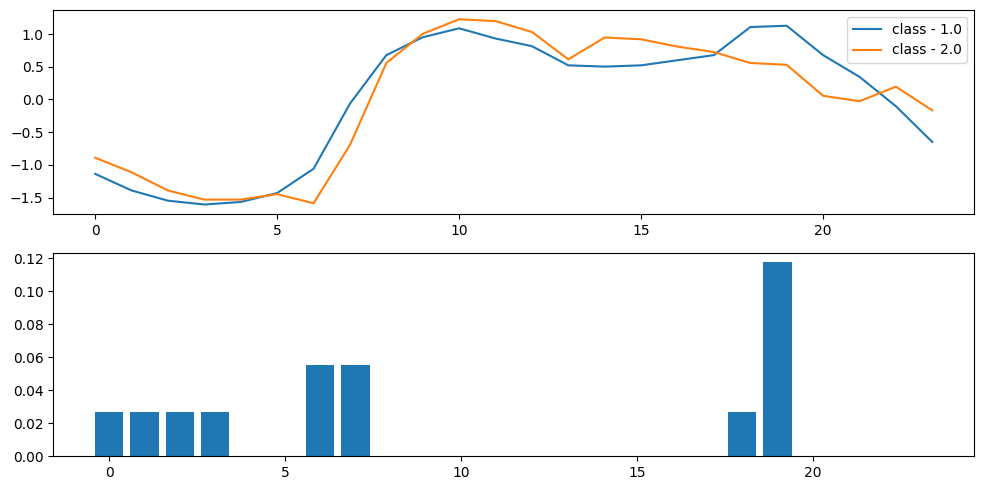

In [50]:
explainer_quantile = Explain(industrial_quantile, test_data[0], test_data[1])
importance_vector_quantile = explainer_quantile.explain(by_n_samples=20)
explainer_quantile.plot_importance_vector_and_time_series(importance_vector_quantile, time_series=1)

In [ ]:
from tqdm import tqdm


class Explain:
    def __init__(self, model, test_features, test_target, window = 3):
        self.model = model
        self.test_features = test_features
        self.test_target = test_target

    def select(self, n_samples: int = 3):
        # df = self.test_features
        selected_df = pd.DataFrame()
        selected_target = np.array([])
        df = self.test_features
        df['target'] = self.test_target

        for class_label in np.unique(self.test_target):
            class_samples = df[df['target'] == class_label].sample(n=n_samples, replace=False)
            selected_df = pd.concat([selected_df, class_samples.iloc[:, :-1]])
            selected_target = np.concatenate([selected_target, class_samples['target'].to_numpy()])

        return selected_df, selected_target

    def explain(self, by_n_samples: int = 2):
        n = self.test_features.shape[1]
        metric_name = self.assess_metric(self.test_target)

        features_part, target_part = self.select(n_samples=by_n_samples)

        # base_metric_value = self.model.get_metrics(target=self.test_target,
        #                                             metric_names=[metric_name])[metric_name]

        self.model.solver.test_features = None
        base_predict = self.model.predict(features=features_part, target=target_part)
        base_metric_value = self.model.get_metrics(target=target_part,
                                                    metric_names=[metric_name])[metric_name]

        importance_vector = np.zeros(n)

        for i in tqdm(range(n - 1)):
            features = features_part.copy()
            # replacement_value = np.mean(features.iloc[:, i].values)
            replacement_value = features.iloc[:, i].values.mean()
            features.iloc[:, i] = replacement_value
            self.model.solver.test_features = None
            # features.iloc[:, i] = np.random.permutation(features.iloc[:, i])
            labels = self.model.predict(features=features, target=target_part)
            # labels = self.model.predict(features=features, target=self.test_target)
            # new_metric_value = self.model.get_metrics(target=self.test_target,
            #                                           metric_names=[metric_name])[metric_name]
            new_metric_value = self.model.get_metrics(target=target_part,
                                                      metric_names=[metric_name])[metric_name]
            importance_vector[i] = base_metric_value / new_metric_value - 1


        return importance_vector

    def plot_importance_vector_and_time_series(self, importance_vector, time_series='random'):
        fig, ax = plt.subplots(2, 1, figsize=(10, 5))

        if time_series is 'random':
            rnd_value = np.random.randint(0, self.test_features.shape[0])
            time_series = self.test_features.iloc[rnd_value, :].values
            ax[0].plot(time_series)

        else:
            select_features, select_target = self.select(n_samples=time_series)
            for idx, cls in enumerate(select_target):
                ax[0].plot(select_features.iloc[idx, :].values, label=f'class - {cls}')

            ax[0].legend()

        # ax[1].plot(importance_vector)
        ax[1].bar(np.arange(len(importance_vector)), importance_vector)
        fig.tight_layout()
        plt.show()

    def assess_metric(self, target):
        n_classes = len(np.unique(target))
        return 'roc_auc' if n_classes == 2 else 'f1'

explainer = Explain(industrial, test_data[0], test_data[1])
importance_vector = explainer.explain(by_n_samples=20)
explainer.plot_importance_vector_and_time_series(importance_vector, time_series=1)


In [22]:
from fedot_ind.api.main import FedotIndustrial
from fedot_ind.tools.loader import DataLoader

dataset_name = 'ItalyPowerDemand'
train_data, test_data = DataLoader(dataset_name=dataset_name).load_data()
industrial_shap = FedotIndustrial(task='ts_classification',
                                 dataset=dataset_name,
                                 strategy='topological',
                                 use_cache=False,
                                 timeout=0.1,
                                 logging_level=50,
                                 available_operations=['scaling', 'normalization', 'xgboost', 'rfr',
                                                       'rf', 'logit', 'mlp', 'knn', 'lgbm', 'pca']
                            )

model_shap = industrial_shap.fit(features=train_data[0], target=train_data[1])
labels_shap = industrial_shap.predict(features=test_data[0], target=test_data[1])
probs_shap = industrial_shap.predict_proba(features=test_data[0], target=test_data[1])
metrics_shap = industrial_shap.get_metrics(target=test_data[1], metric_names=['f1', 'roc_auc', 'accuracy'])

  0%|          | 0/5 [00:00<?, ?it/s]

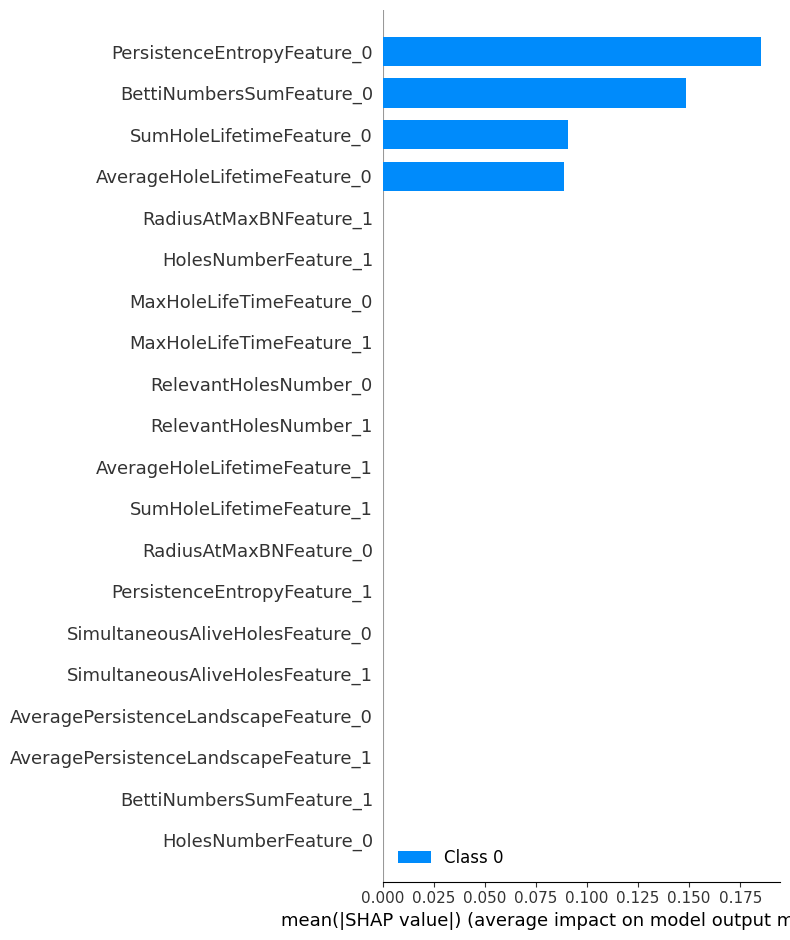

In [74]:
n_samples = 5
X_test = industrial_shap.solver.test_features

explainer = shap.KernelExplainer(industrial_shap.solver.predictor.predict, X_test, n_samples=n_samples)
shap_values = explainer.shap_values(X_test.iloc[:n_samples, :])
shap.summary_plot(shap_values, X_test.iloc[:n_samples, :], plot_type="bar")

In [5]:
n_samples = 5
X_test = industrial.solver.test_features
explainer = shap.KernelExplainer(industrial.solver.predictor.predict, X_test, n_samples=n_samples)
# shap_values = explainer.shap_values(X_test.iloc[:n_samples, :])
# shap.summary_plot(shap_values, X_test.iloc[:n_samples, :], plot_type="bar")
shap_values = explainer.shap_values(X_test[:n_samples, :])
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Create a force plot for a specific instance (e.g., the first instance)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0,:])

TypeError: '(slice(None, 5, None), slice(None, None, None))' is an invalid key

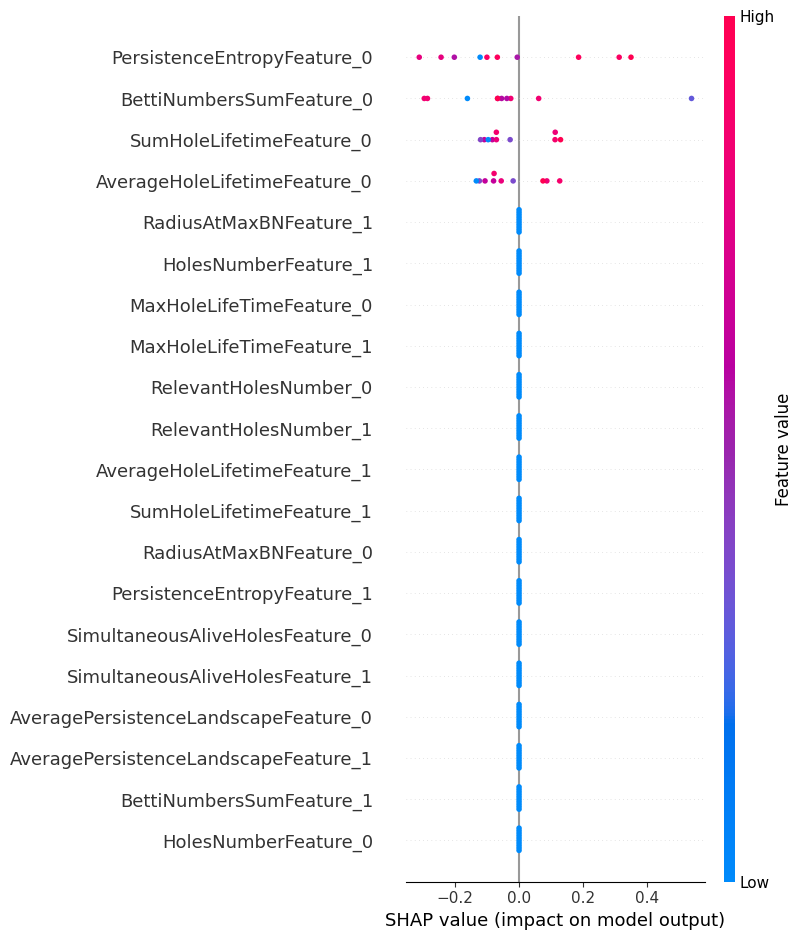

In [55]:
# shap.initjs()
shap.summary_plot(shap_values[0], X_test.iloc[:n_samples, :])

In [9]:
import lime
import lime.lime_tabular


class LimeExplainer:
    def __init__(self, model, train_features, test_features, target, prediction):
        self.model = model
        self.train_features = train_features
        self.test_features = test_features
        self.target = target
        self.prediction = prediction

    def explain(self, n_features, show_all=False):
        class_names = list(map(str, np.unique(self.target)))
        explainer = lime.lime_tabular.LimeTabularExplainer(training_data=self.train_features.values,
                                                           feature_names=self.train_features.columns,
                                                           class_names=class_names,
                                                           discretize_continuous=True)
        i = np.random.randint(0, self.test_features.shape[0])
        exp = explainer.explain_instance(data_row=self.test_features.iloc[i, :].values,
                                         predict_fn=self.model.predict_proba,
                                         num_features=n_features,
                                         top_labels=1
                                         )
        exp.show_in_notebook(show_table=True, show_all=show_all)


In [32]:
from fedot_ind.api.main import FedotIndustrial
from fedot_ind.tools.loader import DataLoader

dataset_name = 'ItalyPowerDemand'
train_data, test_data = DataLoader(dataset_name=dataset_name).load_data()
industrial_topo = FedotIndustrial(task='ts_classification',
                                 dataset=dataset_name,
                                 strategy='topological',
                                 use_cache=False,
                                 timeout=0.1,
                                 logging_level=50,
                                 available_operations=['scaling', 'normalization', 'xgboost', 'rfr',
                                                       'rf', 'logit', 'mlp', 'knn', 'lgbm', 'pca']
                            )

model_topo = industrial_topo.fit(features=train_data[0], target=train_data[1])
labels_topo = industrial_topo.predict(features=test_data[0], target=test_data[1])
probs_topo = industrial_topo.predict_proba(features=test_data[0], target=test_data[1])
metrics_topo = industrial_topo.get_metrics(target=test_data[1], metric_names=['f1', 'roc_auc', 'accuracy'])

In [10]:
exp = LimeExplainer(model=industrial_topo.solver.predictor,
                    train_features=industrial_topo.solver.train_features,
                    test_features=industrial_topo.solver.test_features,
                    target=test_data[1],
                    prediction=industrial_topo.solver.prediction_label,
                    )

exp.explain(n_features=100, show_all=False)

NameError: name 'industrial_topo' is not defined

In [3]:
from fedot_ind.api.main import FedotIndustrial
from fedot_ind.tools.loader import DataLoader

dataset_name = 'ItalyPowerDemand'
train_data, test_data = DataLoader(dataset_name=dataset_name).load_data()
industrial_quantile = FedotIndustrial(task='ts_classification',
                                 dataset=dataset_name,
                                 strategy='quantile',
                                 use_cache=False,
                                 timeout=0.1,
                                 logging_level=50,
                                 available_operations=['scaling', 'normalization', 'xgboost', 'rfr',
                                                       'rf', 'logit', 'mlp', 'knn', 'lgbm', 'pca']
                            )


model_quantile = industrial_quantile.fit(features=train_data[0], target=train_data[1])
labels_quantile = industrial_quantile.predict(features=test_data[0], target=test_data[1])
probs_quantile = industrial_quantile.predict_proba(features=test_data[0], target=test_data[1])
metrics_quantile = industrial_quantile.get_metrics(target=test_data[1], metric_names=['f1',
                                                                                      'roc_auc',
                                                                                      'accuracy'])

2023-11-30 13:30:41,128 INFO: FedotIndustrialAPI - Initialising experiment setup
2023-11-30 13:30:41,130 INFO: Configurator - Experiment setup:
2023-11-30 13:30:41,132 INFO: Configurator - task - ts_classification
2023-11-30 13:30:41,133 INFO: Configurator - dataset - ItalyPowerDemand
2023-11-30 13:30:41,134 INFO: Configurator - strategy - quantile
2023-11-30 13:30:41,136 INFO: Configurator - use_cache - False
2023-11-30 13:30:41,137 INFO: FedotIndustrialAPI - Initialising solver
2023-11-30 13:30:41,139 INFO: TimeSeriesClassifier - TimeSeriesClassifier initialised
2023-11-30 13:30:41,142 INFO: TimeSeriesClassifier - Fitting model


In [11]:
exp_q = LimeExplainer(model=industrial_quantile.solver.predictor,
                    train_features=industrial_quantile.solver.train_features,
                    test_features=industrial_quantile.solver.test_features,
                    target=test_data[1],
                    prediction=industrial_quantile.solver.prediction_label,
                    )

exp_q.explain(n_features=10, show_all=False)

In [ ]:
n_samples = 5
X_test = industrial_quantile.solver.test_features

explainer = shap.KernelExplainer(industrial_quantile.solver.predictor.predict, X_test, n_samples=n_samples)
shap_values = explainer.shap_values(X_test.iloc[:n_samples, :])
shap.summary_plot(shap_values, X_test.iloc[:n_samples, :], plot_type="bar")

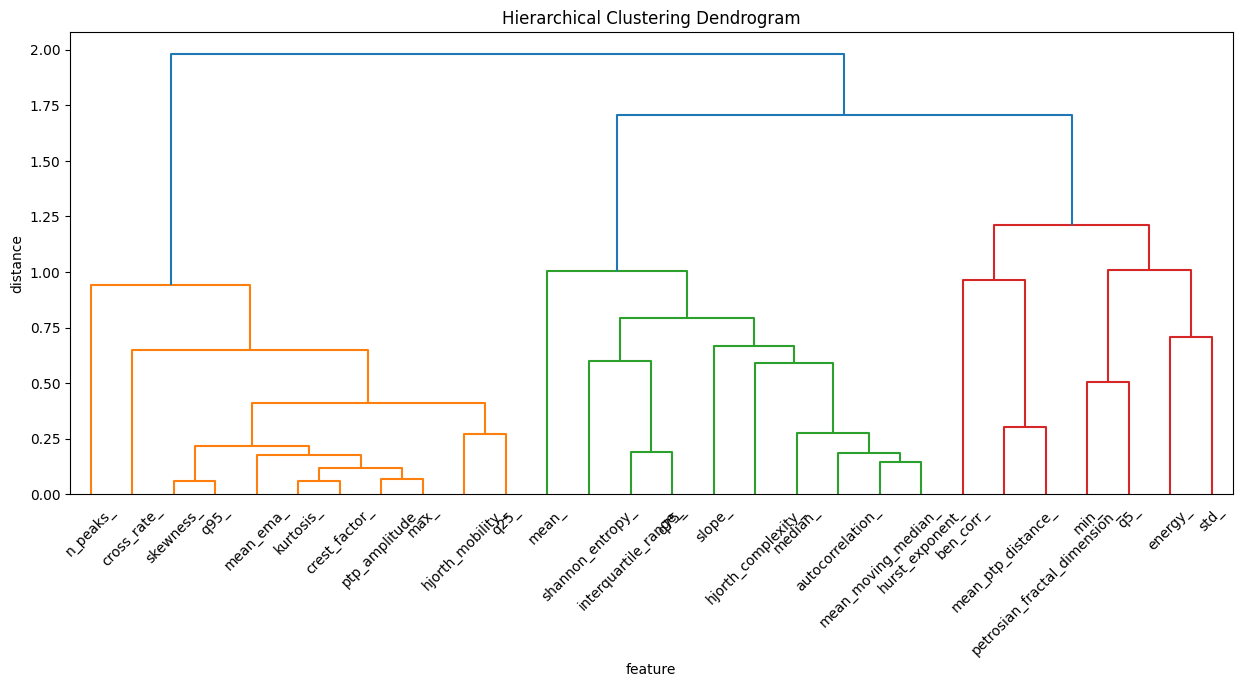

In [6]:
# import scipy as sp
import scipy.cluster

X = industrial_quantile.solver.test_features

partition_tree = shap.utils.partition_tree(X)
plt.figure(figsize=(15, 6))
scipy.cluster.hierarchy.dendrogram(partition_tree, labels=X.columns)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("feature")
plt.ylabel("distance")
plt.show()

In [7]:
industrial_quantile.solver.test_features.columns

Index(['skewness_', 'kurtosis_', 'n_peaks_', 'slope_', 'ben_corr_',
       'interquartile_range_', 'energy_', 'cross_rate_', 'autocorrelation_',
       'shannon_entropy_', 'ptp_amplitude_', 'mean_ptp_distance_',
       'crest_factor_', 'mean_ema_', 'mean_moving_median_', 'hjorth_mobility_',
       'hjorth_complexity_', 'hurst_exponent_', 'petrosian_fractal_dimension_',
       'mean_', 'median_', 'std_', 'max_', 'min_', 'q5_', 'q25_', 'q75_',
       'q95_'],
      dtype='object')

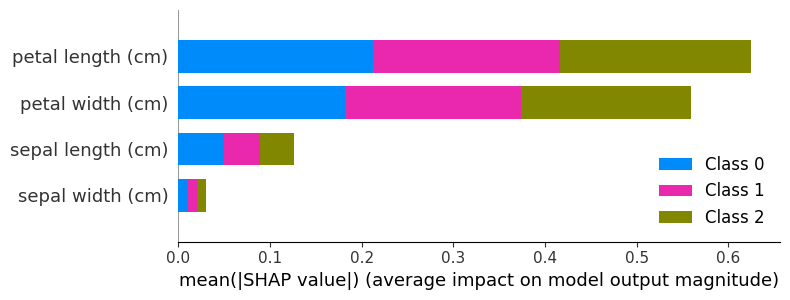

TypeError: In v0.20, force plot now requires the base value as the first parameter! Try shap.plots.force(explainer.expected_value, shap_values) or for multi-output models try shap.plots.force(explainer.expected_value[0], shap_values[0]).

In [21]:
from sklearn.datasets import load_iris
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Load your dataset
# data = pd.read_csv('your_dataset.csv')
# X = data.drop('target_column', axis=1)
# y = data['target_column']
X, y = load_iris(return_X_y=True, as_frame=True)
# Train a model (e.g., RandomForestClassifier)
model = RandomForestClassifier()
model.fit(X, y)

# Create a SHAP explainer
explainer = shap.TreeExplainer(model)

# Calculate SHAP values
shap_values = explainer.shap_values(X)

# Create a summary plot
shap.summary_plot(shap_values, X, plot_type="bar")

# Create a force plot for a specific instance (e.g., the first instance)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X.iloc[0,:])

# Create a heatmap for a specific instance (e.g., the first instance)
# shap.initjs()
# shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:], matplotlib=True)
